## <center>Midterm Lab
```
- Advanced Machine Learning, Innopolis University 
- Professor: Muhammad Fahim 
- Teaching Assistant: Gcinizwe Dlamini
```
<hr>

```
Tasks:
  1. Image Transform (5 points)
  2. CNN model declaration (10 points)
  3. CNN model training (5 points)
  4. Transfer Learning or Viterbi algorithm : Bonus (5 points)
```

<hr>

## The Dataset

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim

import numpy as np

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Task 1 : Preprocessing of Dataset (5 points)

1.   Create the transforms:
    * Resize images to (32 * 32)
    * Normalize every channel (mean and std of your choice)
    * Apply one more data augmentation technique you know (i.e Rotation, translation, RandomErasing, RandomHorizontalFlip etc.)


**Hint**: data augmentation techniques shouldn't be applied to the test dataset.

In [14]:
transform_train = transforms.Compose([
        transforms.Resize((32,32)),
        # transforms.RandomErasing(),
        transforms.RandomRotation((0,15)),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])

transform_test = transforms.Compose([
      transforms.Resize((32,32)),
      transforms.ToTensor(),
      transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])

trainset = torchvision.datasets.SVHN(root='./data/train', split="train", download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=512, shuffle=True, num_workers=1)

testset = torchvision.datasets.SVHN(root='./data/test', split="test", download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=512, shuffle=False, num_workers=1)

classes = [f"{i}" for i in np.unique(trainset.labels)]

Using downloaded and verified file: ./data/train\train_32x32.mat
Using downloaded and verified file: ./data/test\test_32x32.mat


## Task 1.1 Plot Classes distribution 

Plot the distribution of classes in the training sample on a bar graph

<AxesSubplot:>

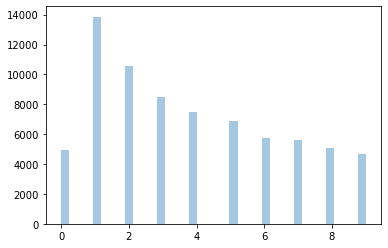

In [4]:
from matplotlib import pyplot as plt
import seaborn as sns
#TODO: Plot the distribution of classes
#Plot Histogram of "size"
sns.distplot(trainset.labels, kde = False)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


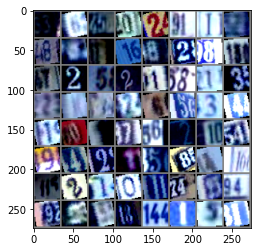

In [5]:
def to_img(x):
    x = 0.5 * (x + 1)
    x = x.clamp(0, 1)
    x = x.view(x.size(0), 3, 32, 32)
    return x

# functions to show an image
def imshow(img):
    img = img / 2 + 0.5 # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

# sample a batch and show 
dataiter = iter(trainloader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images))

## Task 2 : Build a classisfication convolutional neural network


The Model should should have the following achitecture : 
1. 3 Convolution layers : (5 points)
    * conv1 : 2 kernels, 3*3 kernel size, stride 1.
    * conv2 : 4 kernels, 5*5 kernel size, stride 2.
    * conv3 : 8 kernels, 3*3 kernel size, stride 1.
    * Add 1 Avarage pooling layer after 2nd layer and 1 Max-pooling layer before the fully connected layers.
    * Stride for all pooling operations set to 1 
    
    
2. Fully connected layers : 
    * fc1 : 64 output-neurons with a relu activation.
    * output_layer : final layer with no activation function
    * Add Dropout layer after the first (fc1) layer with 25% dropout probability

3. Implement the foward pass method for the CNN  (5 points)
    * Add an activation function of your own choice after every layer
    

In [26]:
conv1 = torch.nn.Conv2d(3, 2, 3, stride=1)(images)
conv2 = torch.nn.Conv2d(2, 4, 5, stride=2)(conv1)
avpool = torch.nn.AvgPool2d(2)(conv2)
conv3 = torch.nn.Conv2d(4, 8, 3, stride=1)(avpool)
maxpool = torch.nn.MaxPool2d(2)(conv3)
        # Max Pooling (2, 2)
fl = maxpool.view(maxpool.size(0),-1)
fc1 = torch.nn.Linear(32, 64)(fl)
fc2 = torch.nn.Linear(64, 10)(fc1)



In [18]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        #TODO: Declare the model layers
        self.conv1 = torch.nn.Conv2d(3, 2, 3, stride=1)
        self.conv2 = torch.nn.Conv2d(2, 4, 5, stride=2,)
        self.avpool = torch.nn.AvgPool2d(2)
        self.conv3 = torch.nn.Conv2d(4, 8, 3, stride=1)
        self.maxpool = torch.nn.MaxPool2d(2)
        # Max Pooling (2, 2)
        # self.conv2 = torch.nn.Conv2d(64, 32 , 2)# Convolution
        self.fc1 = torch.nn.Linear(32, 64)
        self.drop = torch.nn.Dropout(0.15)
        self.fc2 = torch.nn.Linear(64, 10)


    def forward(self, x):
        # TODO: Implement the forward pass
        x = self.conv1(x)
        x = self.conv2(F.relu(x))
        x = self.avpool(F.relu(x))# = torch.nn.AvgPool2d(2)(conv2)
        x = self.conv3(x)# = torch.nn.Conv2d(24, 192, 3, stride=1, padding=1)(avpool)
        x = self.maxpool(F.relu(x))
                # Max Pooling (2, 2)
        x = x.view(x.size(0),-1)
        x = self.fc1(F.relu(x))
        x = self.drop(x)
        x = self.fc2(F.relu(x))
        return x

## Task 3 : Convolutional neural network training precedure (5 points)

Implement the model training procedure and select the appropriate loss function

In [8]:
# Model accuracy calculator 
def accuracy_calc(net,testloader,device):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    return correct / total

In [19]:
model = Net().to(device)
model

Net(
  (conv1): Conv2d(3, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(2, 4, kernel_size=(5, 5), stride=(2, 2), padding=(1, 1))
  (avpool): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (conv3): Conv2d(4, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=72, out_features=10, bias=True)
)

In [22]:
#Set hyper parameters 
nb_epoch = 3
lr = 0.001

optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
criterion = nn.CrossEntropyLoss()#None #TODO: Define the Loss function (criterion)

def train(model,trainloader,optimizer, criterion, device):
    #TODO : Implement the training procedure of the model at each an every epoch. It should return model loss and accuracy on training sample
    running_loss = 0.0
    acc = 0.0
    c = 0
    for i, data in enumerate(trainloader, 0): #TODO: Iterate through the batches and train the cnn
        # TODO : get the inputs and place them to the training devide (i.e GPU or CPU) 
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        # TODO : Train procedure -> zero the parameter gradients, forward pass + backward pass + optimize
        
        outputs = model.forward(inputs)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        acc += accuracy_calc(model, trainloader, device)
        c += 1
        print("running_loss: ",running_loss/c,"\n")
        if i > 5:
            break
        # # print statistics (print every 2000 mini-batches)
        # running_loss += loss.item()
#         if i % 200 == 199:
#             print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 200))
        #     running_loss = 0.0
        #     writer.add_scalar("Loss/train", loss, i)
        #     for tag, parm in net.named_parameters():
        #         if parm.grad is not None:
        #            writer.add_histogram(tag, parm.grad.data.cpu().numpy(), i)
            
    return running_loss/c , acc/c

In [23]:
for epoch in range(nb_epoch):
    epochLoss, epochAcc = train(model,trainloader, optimizer, criterion, device)
    print(f"Epoch : {epoch}, Loss {epochLoss}, Accuracy {epochAcc}")

running_loss:  2.3077316284179688 

running_loss:  2.3140918016433716 

running_loss:  2.313812017440796 

running_loss:  2.313872992992401 

running_loss:  2.313903045654297 

running_loss:  2.3145294189453125 

running_loss:  2.314375502722604 

Epoch : 0, Loss 2.314375502722604, Accuracy 0.14400184087722478
running_loss:  2.31368088722229 

running_loss:  2.3127559423446655 

running_loss:  2.313166936238607 

running_loss:  2.3107816576957703 

running_loss:  2.310074043273926 

running_loss:  2.307870109875997 

running_loss:  2.3078358513968333 

Epoch : 1, Loss 2.3078358513968333, Accuracy 0.14424560110296628
running_loss:  2.303708076477051 

running_loss:  2.303368330001831 

running_loss:  2.3041111628214517 

running_loss:  2.303513467311859 

running_loss:  2.303880739212036 

running_loss:  2.304306904474894 

running_loss:  2.3043605259486606 

Epoch : 2, Loss 2.3043605259486606, Accuracy 0.144395757402023


## Task 4 (bonus) : Use pretrained CNN model or Viterbi implementation (5 points)

**Option 1** : Import any pretrained model and train on CIFAR10. Print out the loss and accuracy at each an every epoch. Number of training epochs and optimizer are of your choice. <br>
**OPtion 2** : Implement the viterbi algorithm (from previous lab task POS tagging) 

In [27]:

import torchvision.models as models

alexnet = models.alexnet(pretrained=True,progress=True)

Downloading: "https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth" to C:\Users\Denis/.cache\torch\hub\checkpoints\alexnet-owt-4df8aa71.pth


In [ ]:
class Net2(nn.Module):
    def __init__(self):
        super(Net2, self).__init__()
        self.net = models.alexnet(pretrained=True,progress=True)
        self.net.trainable = False
        self.net.fc = nn.Linear(512, 10)

    def forward(self, x):
        return self.net(x)


net2 = Net2()
net2 = net2.to(device)

In [ ]:
for epoch in range(nb_epoch):
    epochLoss, epochAcc = train(model,trainloader, optimizer, criterion, device)
    print(f"Epoch : {epoch}, Loss {epochLoss}, Accuracy {epochAcc}")